## Demo Notebook for generating knockoffs
#### This notebook trains a knockoff generator that empolys  sRMMD as the loss. After training, knockoffs are generated and then LASSO regression is applied to compute the knockoff statistics. Average FDR vs. power tradeoff w.r.t. amplitude is shown at the end of the notebook.

In [ ]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LassoCV
from src.gaussian import GaussianKnockoffs
from src.machine import KnockoffGenerator
from sklearn import linear_model
from src.utils import generateSamples, sample_Y, select
from sklearn import preprocessing

In [3]:
n = 2000
d = 100
distType="GaussianAR1" # {'GaussianAR1', 'SparseGaussian', 'GaussianMixtureAR1','MultivariateStudentT'}
dataSampler = generateSamples(distType,d )
xTrain = dataSampler.sample(n)
SigmaHat = np.cov(xTrain, rowvar=False)
second_order = GaussianKnockoffs(SigmaHat, mu=np.mean(xTrain,0), method="sdp")
corr_g = (np.diag(SigmaHat) - np.diag(second_order.Ds)) / np.diag(SigmaHat)

In [5]:
pars={"epochs":100, 
      "epoch_length": 20, 
      "d": d,
      "dim_h": int(6*d),
      "batch_size": int(n/4), 
      "lr": 0.01, 
      "lr_milestones": [100],
      "GAMMA":1, 
      "losstype": 'sRMMD', # {sRE, mmd, sRMMD}
      "epsilon":100,
      "target_corr": corr_g,
      "sigmas":[1.,2.,4.,8.,16.,32.,64.,128.]
     }

In [6]:
machine = KnockoffGenerator(pars)
machine.train(xTrain)

[   1/ 100], Loss: 0.0633, sRMMD : 0.0318, Decorr: 0.444
[   2/ 100], Loss: 0.0281, sRMMD : 0.0266, Decorr: 0.447
[   3/ 100], Loss: 0.0209, sRMMD : 0.0196, Decorr: 0.452
[   4/ 100], Loss: 0.0199, sRMMD : 0.0187, Decorr: 0.450
[   5/ 100], Loss: 0.0191, sRMMD : 0.0180, Decorr: 0.455
[   6/ 100], Loss: 0.0203, sRMMD : 0.0192, Decorr: 0.457
[   7/ 100], Loss: 0.0177, sRMMD : 0.0166, Decorr: 0.455
[   8/ 100], Loss: 0.0186, sRMMD : 0.0174, Decorr: 0.461
[   9/ 100], Loss: 0.0175, sRMMD : 0.0163, Decorr: 0.449
[  10/ 100], Loss: 0.0167, sRMMD : 0.0157, Decorr: 0.454
[  11/ 100], Loss: 0.0164, sRMMD : 0.0153, Decorr: 0.454
[  12/ 100], Loss: 0.0161, sRMMD : 0.0150, Decorr: 0.456
[  13/ 100], Loss: 0.0158, sRMMD : 0.0147, Decorr: 0.456
[  14/ 100], Loss: 0.0151, sRMMD : 0.0140, Decorr: 0.445
[  15/ 100], Loss: 0.0151, sRMMD : 0.0140, Decorr: 0.453
[  16/ 100], Loss: 0.0148, sRMMD : 0.0138, Decorr: 0.447
[  17/ 100], Loss: 0.0156, sRMMD : 0.0146, Decorr: 0.449
[  18/ 100], Loss: 0.0146, sRMM

In [27]:
signal_n = 20 # no of nonzero entries
n_experiments = 100 
nominal_fdr = 0.1
signal_amplitude_vec =  [3, 5, 10, 15, 20, 25, 30]
results_pow = pd.DataFrame(columns=['amp', 'srmmd'])
results_fdp = pd.DataFrame(columns=['amp', 'srmmd'])
for amp_id in range(len(signal_amplitude_vec)):
    FDP, POW= [],[]
    signal_amplitude = signal_amplitude_vec[amp_id]
    print("Running %d experiments with signal amplitude: %.2f" %(n_experiments,signal_amplitude))
    for i in range(n_experiments):
        xTest = dataSampler.sample(n= 200)
        xsRMMD= machine.generate(xTest)
        y,theta = sample_Y(xTest, signal_n=signal_n, signal_a=signal_amplitude)
        concat_X = np.concatenate((xTest, xsRMMD), axis = 1)
        if i == 0: # to save computational time, we only compute the optimal lasso penalty for one instance
            reg = LassoCV(cv = 10, normalize= True, random_state = 0).fit(concat_X, y)
            alpha = reg.alpha_ # optimal lasso penalty
        clf = linear_model.Lasso(alpha = alpha, normalize= True, max_iter = 250000)
        clf.fit(concat_X, y)
        Z = clf.coef_
        W = np.abs(Z[:d]) - np.abs(Z[d:])
        selected, fdp, power = select(W, theta, nominal_fdr=nominal_fdr)
        FDP.append(fdp)
        POW.append(power)
    results_pow=  results_pow.append({'amp': signal_amplitude,'srmmd': np.mean(POW)}, ignore_index = True)
    results_fdp = results_fdp.append({'amp': signal_amplitude,'srmmd': np.mean(FDP)}, ignore_index = True)

Running 100 experiments with signal amplitude: 3.00
Running 100 experiments with signal amplitude: 5.00
Running 100 experiments with signal amplitude: 10.00
Running 100 experiments with signal amplitude: 15.00
Running 100 experiments with signal amplitude: 20.00
Running 100 experiments with signal amplitude: 25.00
Running 100 experiments with signal amplitude: 30.00


(-0.015, 0.5)

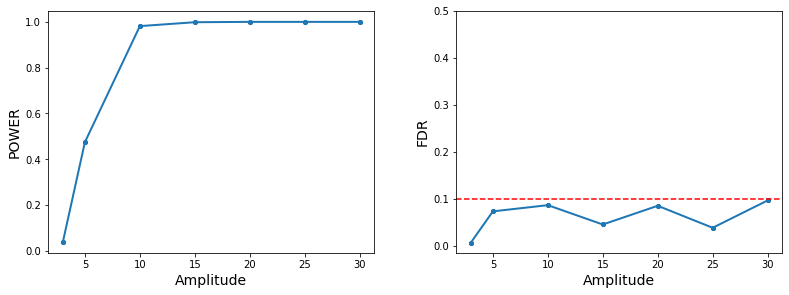

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=.2, wspace=.25)
ax[0].plot(signal_amplitude_vec, results_pow['srmmd'], "-8", markersize=5, linewidth = 2)
ax[0].set_xlabel('Amplitude', fontsize = 14)
ax[0].set_ylabel('POWER', fontsize = 14)
ax[1].plot(signal_amplitude_vec, results_fdp['srmmd'], "-8", markersize=5, linewidth = 2)
ax[1].set_xlabel('Amplitude', fontsize = 14)
ax[1].set_ylabel('FDR', fontsize = 14)
ax[1].axhline(y=0.1, color='red', linestyle='--')
ax[1].set_ylim([-0.015,0.5])